# Vanilla GAN

In [1]:
%load_ext autoreload
%matplotlib inline

In [8]:
%autoreload 2

from IPython import display

from utils import Logger

import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

In [3]:
DATA_FOLDER = './torch_data/VGAN/MNIST'

In [4]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5,), (.5,))
        ])
    out_dir = '{}/dataset'.format(DATA_FOLDER)
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

In [5]:
data = mnist_data()
# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader)

100.1%

Extracting ./torch_data/VGAN/MNIST/dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./torch_data/VGAN/MNIST/dataset/MNIST/raw


113.5%

Extracting ./torch_data/VGAN/MNIST/dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./torch_data/VGAN/MNIST/dataset/MNIST/raw


100.4%

Extracting ./torch_data/VGAN/MNIST/dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./torch_data/VGAN/MNIST/dataset/MNIST/raw


180.4%/opt/conda/conda-bld/pytorch_1587428207430/work/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Extracting ./torch_data/VGAN/MNIST/dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./torch_data/VGAN/MNIST/dataset/MNIST/raw
Processing...
Done!


In [51]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        n_input = 784
        n_out = 1
        
        self.layer0 = nn.Sequential( 
            nn.Linear(n_input, 1024),
            nn.ReLU(),
            nn.Dropout(0.4)
        )
        self.layer1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.4)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4)
        )
        self.layer3 = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x
        
def image_to_vector(image):
    return image.view(image.size(0), 784)

def vector_to_image(vector):
    return vector.view(vector.size(0), 1, 28, 28)

In [64]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        n_inputs = 100
        n_out = 784
        
        self.layer0 = nn.Sequential(
            nn.Linear(n_inputs, 256),
            nn.ReLU()
        )
        
        self.layer1 = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU()
        )
        
        self.layer2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.ReLU()
        )
        
        self.layer3 = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

def noise(size):
    n = Variable(torch.randn(size,100))
    if torch.cuda.is_available(): return n.cuda() 
    return n

In [65]:
discriminator = Discriminator()
generator = Generator()
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

In [66]:
print(discriminator)
print(generator)

Discriminator(
  (layer0): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
  )
  (layer1): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
  )
  (layer2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
  )
  (layer3): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
    (1): Sigmoid()
  )
)
Generator(
  (layer0): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): ReLU()
  )
  (layer1): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=1024, out_features=784, bias=True)
    (1): Tanh()
  )
)


In [67]:
d_optimizer = optim.Adam(discriminator.parameters(), lr = 0.0001)
g_optimizer = optim.Adam(generator.parameters(), lr = 0.0001)

loss = nn.BCELoss()
d_steps = 1
epochs = 200

In [68]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

In [69]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [70]:
num_test_samples = 16
test_noise = noise(num_test_samples)

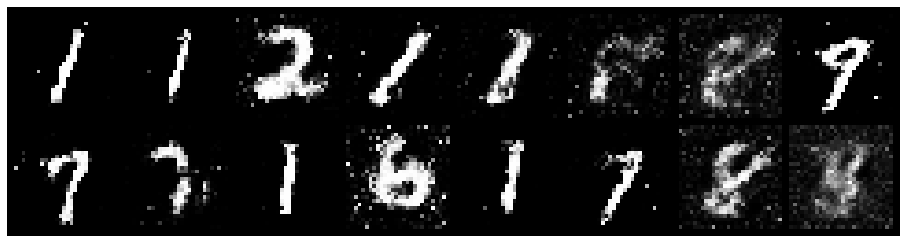

Epoch: [40/200], Batch Num: [100/600]
Discriminator Loss: 1.0404, Generator Loss: 1.2824
D(x): 0.6750, D(G(z)): 0.3861


In [ ]:
logger = Logger(model_name='VGAN', data_name='MNIST')

for epoch in range(epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):

        # 1. Train Discriminator
        real_data = Variable(image_to_vector(real_batch))
        if torch.cuda.is_available(): real_data = real_data.cuda()
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)

        # Display Progress
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            # Display Images
            test_images = vector_to_image(generator(test_noise)).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
        # Model Checkpoints
        logger.save_models(generator, discriminator, epoch)